In [83]:
# Imports & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    make_scorer
)

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# ---------- Load preprocessed data ----------
df = pd.read_csv("processed_data_full.csv")

# Make sure Date is datetime and sort chronologically
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (8736, 26)
Columns: ['Hour', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Solar_Radiation', 'Rainfall', 'Snowfall', 'is_weekend', 'hour_sin', 'hour_cos', 'lag_24h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_std_6h', 'rolling_mean_24h', 'temp_hour', 'temp_squared', 'wind_rain', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Holiday_No Holiday', 'Functioning_Day_Yes', 'High_Demand', 'Date']


In [85]:
# Document Binary Target Definition (75th Percentile)

# High_Demand was created in the preprocessing pipeline using the 75th percentile of Rented_Bike_Count in the raw dataset.
# That threshold was:
threshold = 1065.25
print("Binary target 'High_Demand' was created upstream using the 75th percentile.")
print(f"  Threshold: {threshold:.2f} bikes")

# Check that High_Demand exists and is binary
assert "High_Demand" in df.columns, "'High_Demand' not found in processed_data_full.csv"
print("\nHigh_Demand unique values:", df["High_Demand"].unique())
high_demand_rate = df["High_Demand"].mean() * 100
print(f"  High-Demand prevalence in processed data: {high_demand_rate:.1f}% of hours")

Binary target 'High_Demand' was created upstream using the 75th percentile.
  Threshold: 1065.25 bikes

High_Demand unique values: [0 1]
  High-Demand prevalence in processed data: 25.1% of hours


In [86]:
# Chronological Train/Test Split (80/20)
X_all = df.drop(["High_Demand", "Date"], axis=1)
y_all = df["High_Demand"]

n = len(df)
cut = int(n * 0.8)

train_df = df.iloc[:cut].copy()
test_df  = df.iloc[cut:].copy()

X_train = train_df.drop(["High_Demand", "Date"], axis=1)
y_train = train_df["High_Demand"]
X_test  = test_df.drop(["High_Demand", "Date"], axis=1)
y_test  = test_df["High_Demand"]

print("Train size:", len(X_train))
print("Test size :", len(X_test))

# Class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining class distribution:")
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt} ({cnt / len(y_train):.2%})")

Train size: 6988
Test size : 1748

Training class distribution:
  Class 0: 5298 (75.82%)
  Class 1: 1690 (24.18%)


In [88]:
# TimeSeriesSplit, Imbalance & Safe F1 Scorer
tscv = TimeSeriesSplit(n_splits=5)

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight (neg/pos) = {scale_pos_weight:.3f}")

# Safe F1 scorer: returns 0.0 if a fold's y_true has no positive class
def safe_f1(y_true, y_pred):
    if 1 not in np.unique(y_true):
        return 0.0
    return f1_score(y_true, y_pred, zero_division=0)

f1_scorer = make_scorer(safe_f1)

scale_pos_weight (neg/pos) = 3.135


In [89]:
# XGBoost – Stage 1 Grid Search
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

param_grid_stage1 = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [1.0, scale_pos_weight]
}

grid_xgb_stage1 = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_stage1,
    cv=tscv,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("=== Stage 1: XGBoost Grid Search ===")
grid_xgb_stage1.fit(X_train, y_train)

xgb_model_stage1 = grid_xgb_stage1.best_estimator_
print(f"[Stage 1] Best params: {grid_xgb_stage1.best_params_}")
print(f"[Stage 1] Best CV F1-score: {grid_xgb_stage1.best_score_:.4f}")

=== Stage 1: XGBoost Grid Search ===
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[Stage 1] Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400, 'scale_pos_weight': np.float64(3.1349112426035504), 'subsample': 0.8}
[Stage 1] Best CV F1-score: 0.6718


In [90]:
# XGBoost – Stage 2 Refined Grid Search
best_params = grid_xgb_stage1.best_params_.copy()
print("Base params for Stage 2:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

def around_int(value, low=1, high=15, step=1):
    value = int(value)
    candidates = {value}
    if value - step >= low:
        candidates.add(value - step)
    if value + step <= high:
        candidates.add(value + step)
    return sorted(candidates)

def around_float(value, factor=0.5, lower=0.01, upper=0.3):
    value = float(value)
    return sorted({
        max(lower, value * (1 - factor)),
        value,
        min(upper, value * (1 + factor))
    })

param_grid_stage2 = {
    "n_estimators": sorted(set([
        max(50, best_params["n_estimators"] - 100),
        best_params["n_estimators"],
        best_params["n_estimators"] + 100
    ])),
    "max_depth": around_int(best_params["max_depth"], low=2, high=10),
    "learning_rate": around_float(best_params["learning_rate"], factor=0.5),
    "subsample": [best_params["subsample"]],
    "colsample_bytree": [best_params["colsample_bytree"]],
    "scale_pos_weight": [best_params["scale_pos_weight"]]
}

print("\nStage 2 param grid:")
for k, v in param_grid_stage2.items():
    print(f"  {k}: {v}")

xgb_stage2 = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

grid_xgb_stage2 = GridSearchCV(
    estimator=xgb_stage2,
    param_grid=param_grid_stage2,
    cv=tscv,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\n=== Stage 2: XGBoost Grid Search (Refined) ===")
grid_xgb_stage2.fit(X_train, y_train)

final_xgb = grid_xgb_stage2.best_estimator_
print(f"\n[Stage 2] Best params: {grid_xgb_stage2.best_params_}")
print(f"[Stage 2] Best CV F1-score: {grid_xgb_stage2.best_score_:.4f}")

Base params for Stage 2:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 5
  n_estimators: 400
  scale_pos_weight: 3.1349112426035504
  subsample: 0.8

Stage 2 param grid:
  n_estimators: [300, 400, 500]
  max_depth: [4, 5, 6]
  learning_rate: [0.025, 0.05, 0.07500000000000001]
  subsample: [0.8]
  colsample_bytree: [0.8]
  scale_pos_weight: [np.float64(3.1349112426035504)]

=== Stage 2: XGBoost Grid Search (Refined) ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits

[Stage 2] Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'scale_pos_weight': np.float64(3.1349112426035504), 'subsample': 0.8}
[Stage 2] Best CV F1-score: 0.6753


In [91]:
# Evaluation on Chronological Test Set
y_pred = final_xgb.predict(X_test)
y_proba = final_xgb.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_pred)

metrics = {
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": test_f1,
    "ROC-AUC": roc_auc_score(y_test, y_proba)
}

cm = confusion_matrix(y_test, y_pred)

metrics_df = pd.DataFrame([metrics])
print("=== Test Set Performance (XGBoost) ===")
print(metrics_df.to_string(index=False))

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

=== Test Set Performance (XGBoost) ===
  Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
XGBoost  0.979405   0.967742    0.96  0.963855 0.998127

Confusion Matrix:
[[1232   16]
 [  20  480]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9840    0.9872    0.9856      1248
           1     0.9677    0.9600    0.9639       500

    accuracy                         0.9794      1748
   macro avg     0.9759    0.9736    0.9747      1748
weighted avg     0.9794    0.9794    0.9794      1748



Top 10 Features by XGBoost Importance:
        feature  importance
rolling_mean_3h    0.352613
        lag_24h    0.090361
      wind_rain    0.074488
 rolling_std_3h    0.069973
           Hour    0.065367
       hour_sin    0.064993
      temp_hour    0.048817
       Rainfall    0.046845
     is_weekend    0.025504
       hour_cos    0.025314


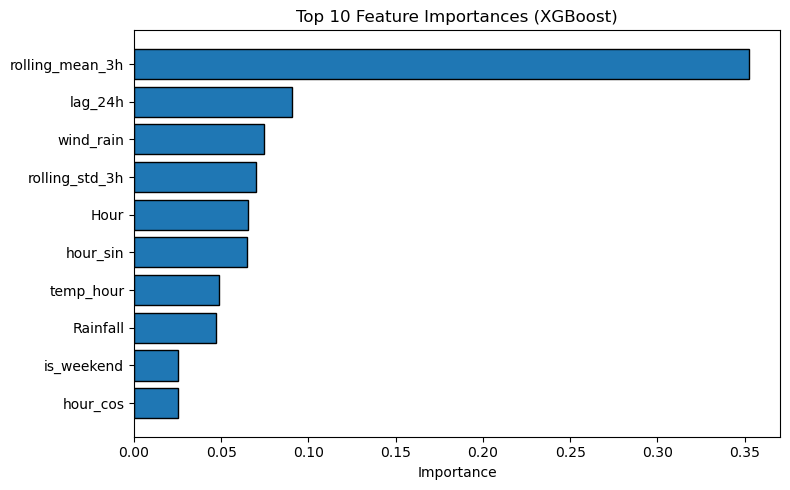

In [92]:
# Feature Importance (Top 10)
importances = final_xgb.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 10 Features by XGBoost Importance:")
print(feat_imp.head(10).to_string(index=False))

plt.figure(figsize=(8, 5))
plt.barh(
    feat_imp["feature"].head(10)[::-1],
    feat_imp["importance"].head(10)[::-1],
    edgecolor="black"
)
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

In [93]:
# Error DataFrame Aligned with Test Set
df_err = test_df.copy()  # chronologically last 20%

df_err["Actual"] = y_test.values
df_err["Predicted"] = y_pred
df_err["Error"] = (df_err["Actual"] != df_err["Predicted"]).astype(int)

df_err["error_type"] = "Correct"
df_err.loc[(df_err["Actual"] == 0) & (df_err["Predicted"] == 1), "error_type"] = "False Positive"
df_err.loc[(df_err["Actual"] == 1) & (df_err["Predicted"] == 0), "error_type"] = "False Negative"

df_err["YearMonth"] = df_err["Date"].dt.to_period("M")
df_err["Month"] = df_err["Date"].dt.month
df_err["DayOfWeek"] = df_err["Date"].dt.dayofweek

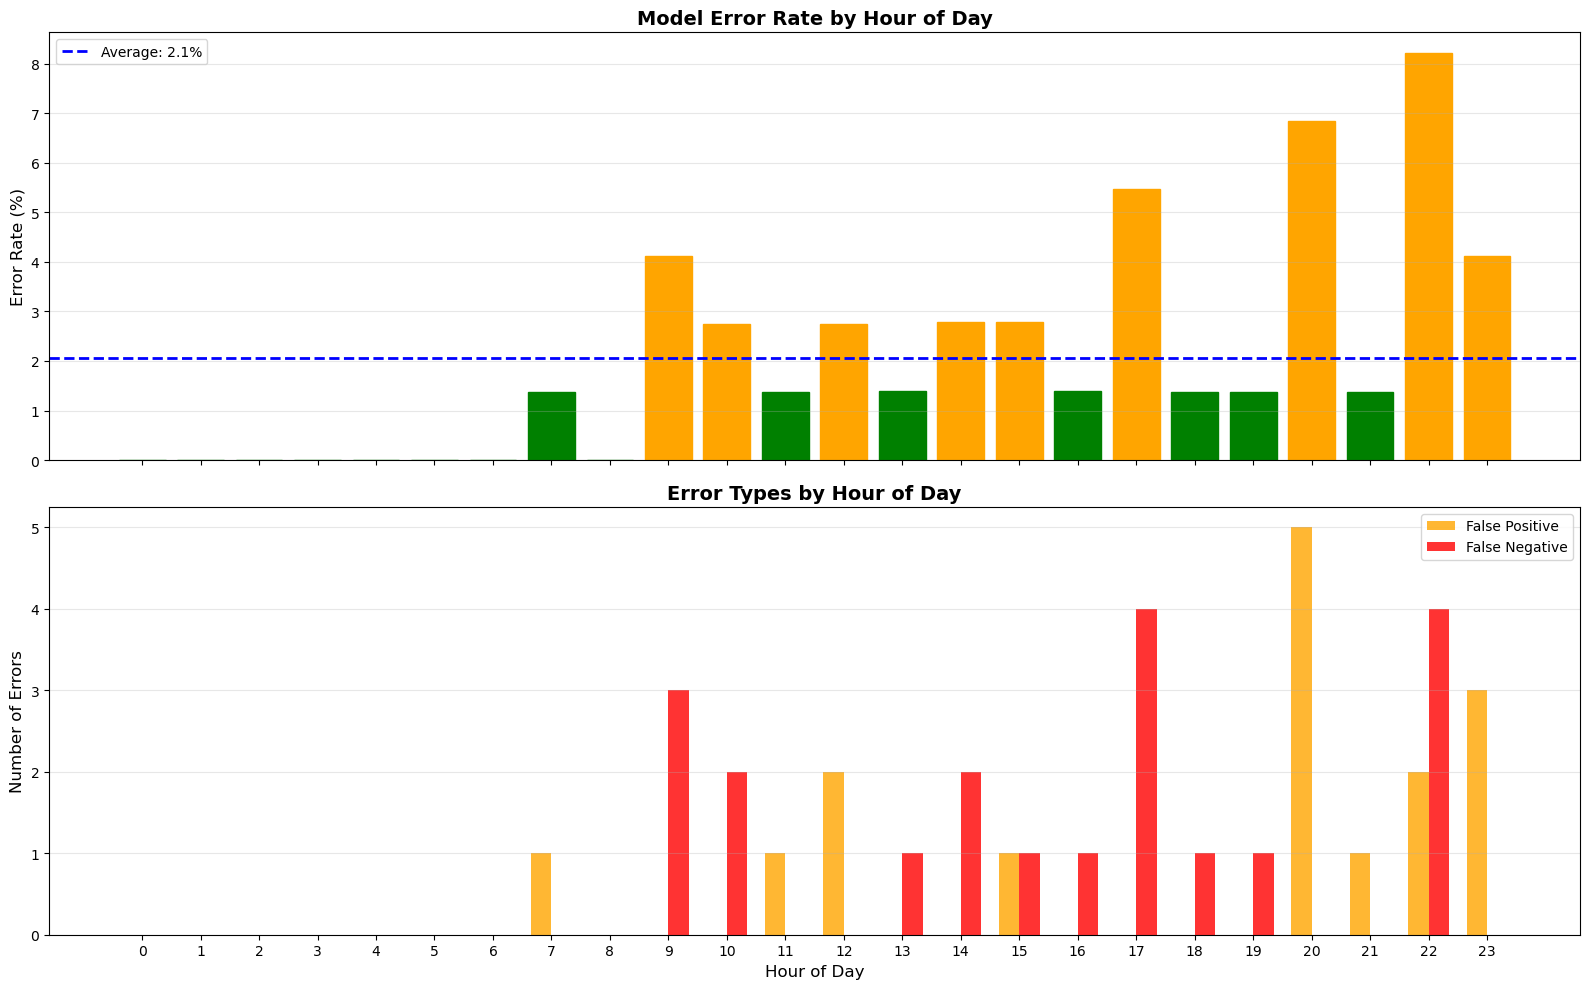

In [94]:
# Error by Hour & Error Types (two stacked plots)

# Aggregate error rate by hour
error_by_hour = (
    df_err.groupby("Hour")["Error"]
    .agg(["sum", "count", "mean"])
    .reset_index()
    .rename(columns={"sum": "Errors", "count": "Total", "mean": "Error_Rate"})
)

# Error type counts by hour
error_types_by_hour = (
    df_err.groupby(["Hour", "error_type"])
    .size()
    .unstack(fill_value=0)
)

hours = np.arange(24)
error_rate_dict = dict(zip(error_by_hour["Hour"], error_by_hour["Error_Rate"]))

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Top panel: error rate by hour
ax1 = axes[0]
rates = np.array([error_rate_dict.get(h, 0.0) for h in hours]) * 100.0
bars = ax1.bar(hours, rates, edgecolor="black")

avg_error = rates.mean()
for b, r in zip(bars, rates):
    if r <= avg_error:
        b.set_color("green")
    else:
        b.set_color("orange")

ax1.axhline(
    avg_error,
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Average: {avg_error:.1f}%"
)

ax1.set_title("Model Error Rate by Hour of Day", fontsize=14, fontweight="bold")
ax1.set_ylabel("Error Rate (%)", fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(axis="y", alpha=0.3)

# Bottom panel: error types by hour
ax2 = axes[1]

fp_counts = [error_types_by_hour.loc[h, "False Positive"] if ("False Positive" in error_types_by_hour.columns and h in error_types_by_hour.index) else 0
             for h in hours]
fn_counts = [error_types_by_hour.loc[h, "False Negative"] if ("False Negative" in error_types_by_hour.columns and h in error_types_by_hour.index) else 0
             for h in hours]

width = 0.35
ax2.bar(hours - width/2, fp_counts, width,
        label="False Positive", color="orange", alpha=0.8)
ax2.bar(hours + width/2, fn_counts, width,
        label="False Negative", color="red", alpha=0.8)

ax2.set_title("Error Types by Hour of Day", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Number of Errors", fontsize=12)
ax2.set_xticks(hours)
ax2.legend(fontsize=10)
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [95]:
# Reconstruct Season / Holiday / Functioning_Day
def infer_season(row):
    if row["Seasons_Spring"]:
        return "Spring"
    elif row["Seasons_Summer"]:
        return "Summer"
    elif row["Seasons_Winter"]:
        return "Winter"
    else:
        return "Autumn"

df_err["Season"] = df_err.apply(infer_season, axis=1)

def infer_holiday(row):
    return "No Holiday" if row["Holiday_No Holiday"] else "Holiday"

df_err["Holiday"] = df_err.apply(infer_holiday, axis=1)

df_err["Functioning_Day"] = df_err["Functioning_Day_Yes"].map({True: "Yes", False: "No"})

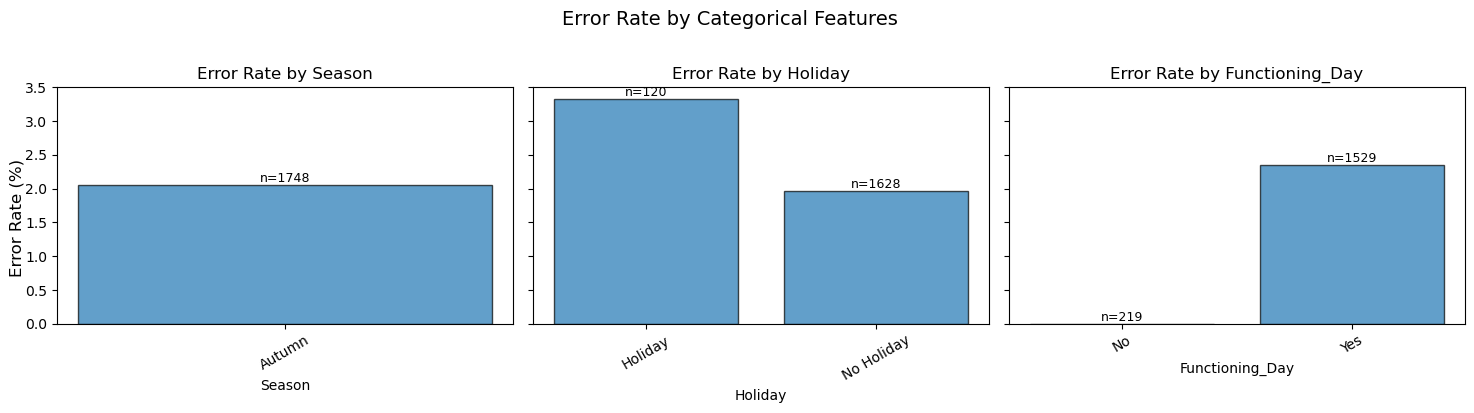

In [97]:
# Error Rate by Categorical Features
categorical_features = ["Season", "Holiday", "Functioning_Day"]

def plot_error_by_categorical_features(df_err, features, min_count=30):
    n_feats = len(features)
    fig, axes = plt.subplots(1, n_feats, figsize=(5 * n_feats, 4), sharey=True)

    if n_feats == 1:
        axes = [axes]

    for ax, feature in zip(axes, features):
        data = df_err[[feature, "Error"]].dropna().copy()

        stats = (
            data.groupby(feature)["Error"]
            .agg(["mean", "count"])
            .reset_index()
            .rename(columns={"mean": "Error_Rate", "count": "Count"})
        )

        stats = stats[stats["Count"] >= min_count]
        if stats.empty:
            ax.set_visible(False)
            continue

        bars = ax.bar(
            stats[feature].astype(str),
            stats["Error_Rate"] * 100,
            alpha=0.7,
            edgecolor="black"
        )
        ax.set_xlabel(feature)
        ax.set_title(f"Error Rate by {feature}")
        ax.tick_params(axis="x", rotation=30)

        # n= counts on top of bars
        for bar, (_, row) in zip(bars, stats.iterrows()):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"n={int(row['Count'])}",
                ha="center",
                va="bottom",
                fontsize=9
            )

    fig.supylabel("Error Rate (%)")
    fig.suptitle("Error Rate by Categorical Features", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()

plot_error_by_categorical_features(df_err, categorical_features, min_count=30)

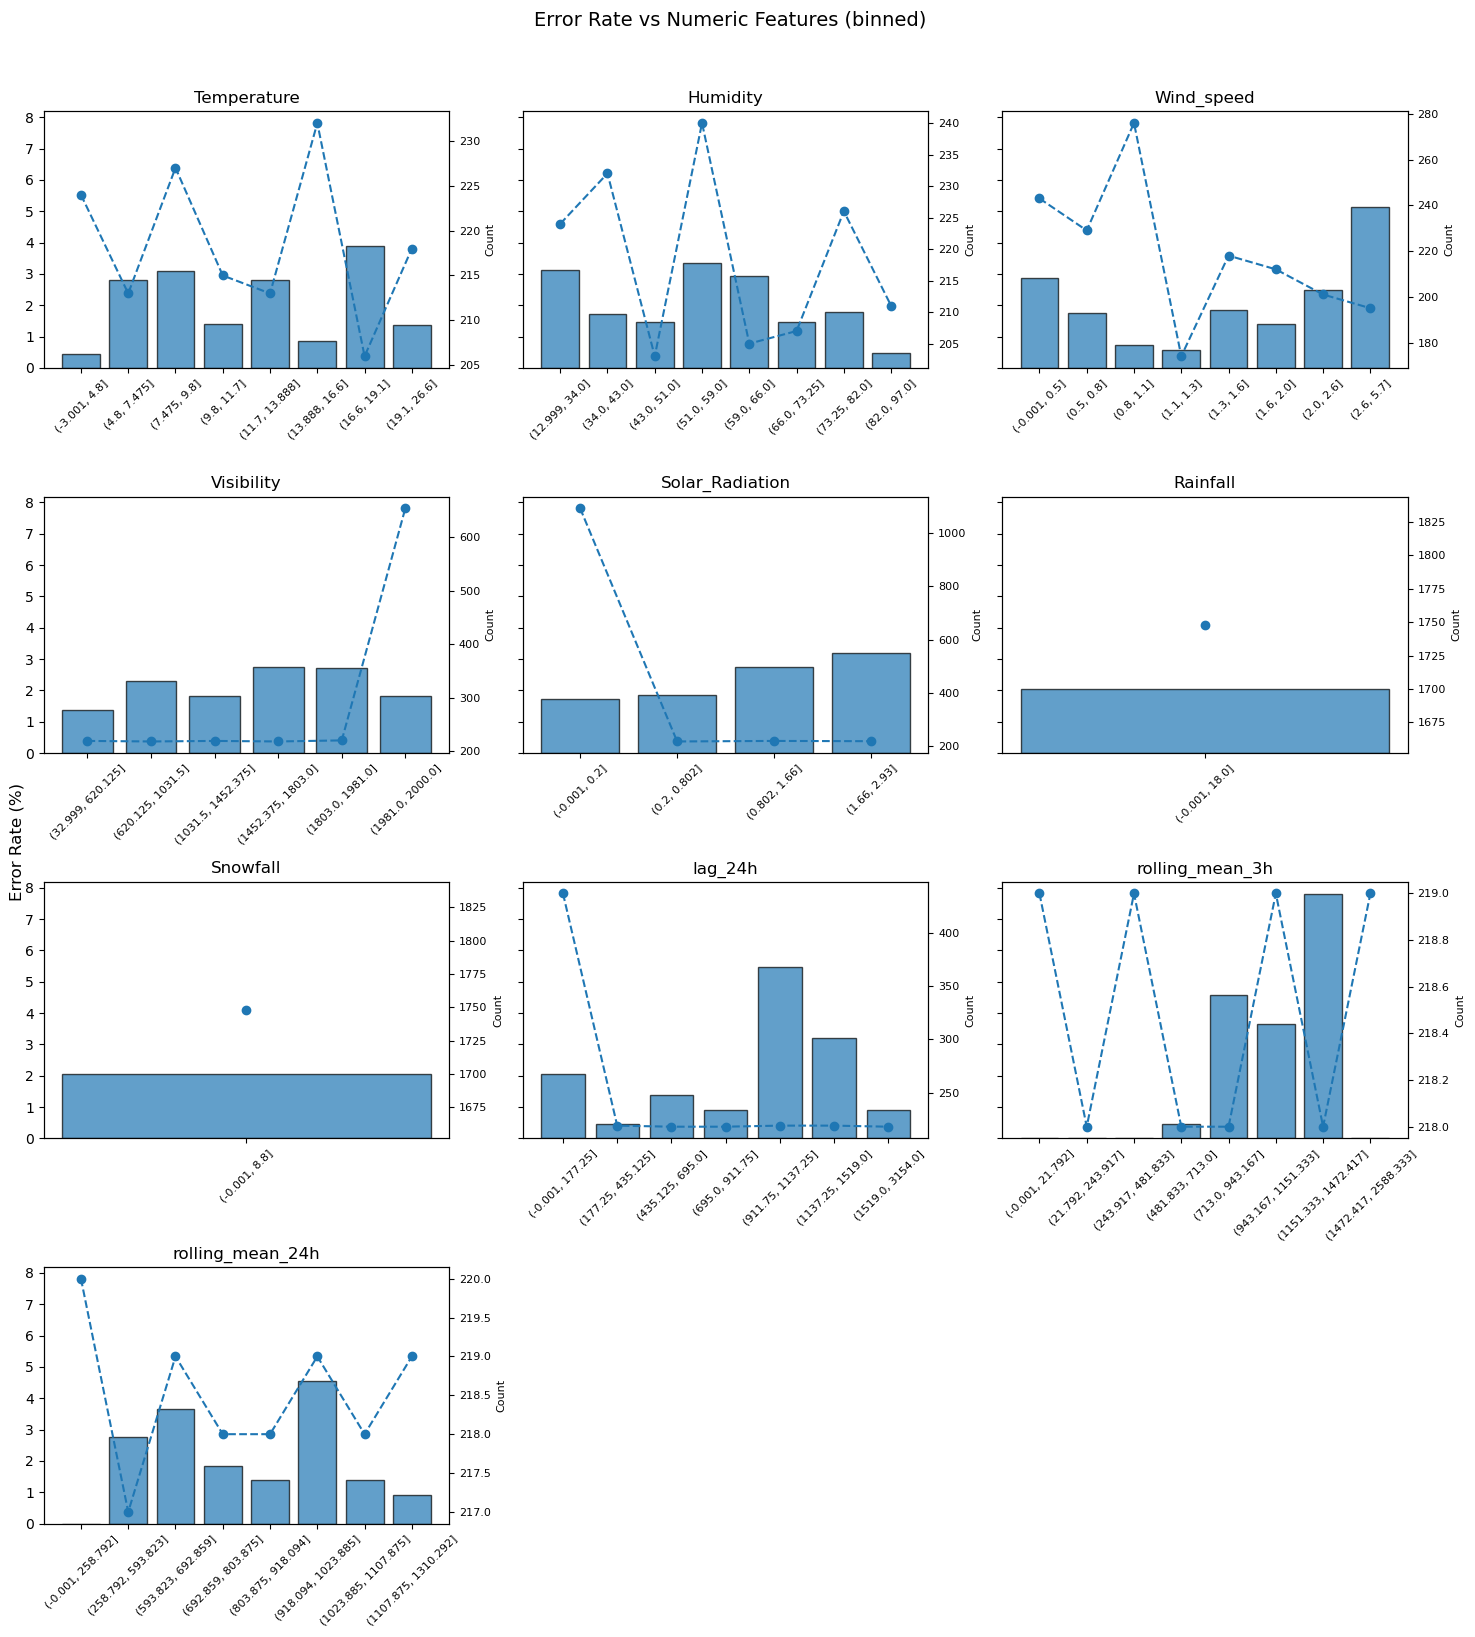

In [98]:
# Error vs Numeric Features
numeric_features = [
    "Temperature",
    "Humidity",
    "Wind_speed",
    "Visibility",
    "Solar_Radiation",
    "Rainfall",
    "Snowfall",
    "lag_24h",
    "rolling_mean_3h",
    "rolling_mean_6h",
    "rolling_mean_24h"
]

def plot_error_by_numeric_features(df_err, features, bins=8, n_cols=3):
    valid_feats = [f for f in features if f in df_err.columns]
    if not valid_feats:
        print("No valid numeric features in df_err.")
        return

    n_feats = len(valid_feats)
    n_rows = int(np.ceil(n_feats / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        sharey=True
    )
    axes = np.array(axes).reshape(-1)

    for ax, feature in zip(axes, valid_feats):
        data = df_err[[feature, "Error"]].dropna().copy()
        if data.empty:
            ax.set_visible(False)
            continue

        data["bin"] = pd.qcut(data[feature], q=bins, duplicates="drop")

        error_by_bin = (
            data.groupby("bin")["Error"]
            .mean()
            .reset_index(name="Error_Rate")
        )
        count_by_bin = (
            data.groupby("bin")["Error"]
            .count()
            .reset_index(name="Count")
        )
        merged = error_by_bin.merge(count_by_bin, on="bin")

        # Bars = error rate
        ax.bar(
            merged["bin"].astype(str),
            merged["Error_Rate"] * 100,
            alpha=0.7,
            edgecolor="black"
        )
        ax.set_title(feature)
        ax.tick_params(axis="x", rotation=45, labelsize=8)

        # Dotted line = count
        ax2 = ax.twinx()
        ax2.plot(
            merged["bin"].astype(str),
            merged["Count"],
            marker="o",
            linestyle="--"
        )
        ax2.tick_params(axis="y", labelsize=8)
        ax2.set_ylabel("Count", fontsize=8)

    for ax in axes[len(valid_feats):]:
        ax.set_visible(False)

    fig.supylabel("Error Rate (%)")
    fig.suptitle("Error Rate vs Numeric Features (binned)", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()

plot_error_by_numeric_features(df_err, numeric_features, bins=8, n_cols=3)

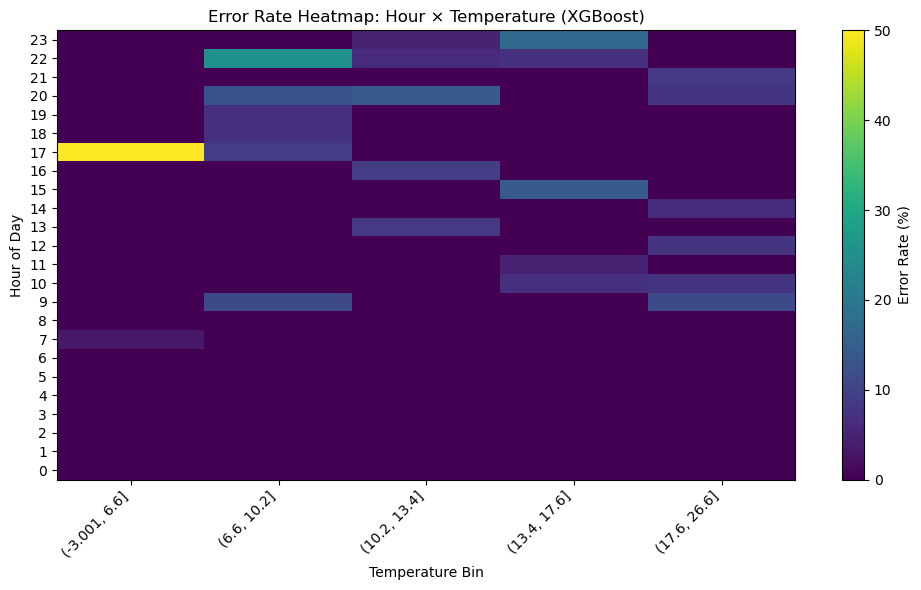

In [99]:
# Error Heatmap: Hour × Temperature
temp_col = "Temperature"
if temp_col in df_err.columns:
    df_2d = df_err[["Hour", temp_col, "Error"]].dropna().copy()
    df_2d["Temp_bin"] = pd.qcut(df_2d[temp_col], q=5, duplicates="drop")

    error_2d = (
        df_2d.groupby(["Hour", "Temp_bin"])["Error"]
        .mean()
        .reset_index()
    )

    pivot = error_2d.pivot(index="Hour", columns="Temp_bin", values="Error")

    plt.figure(figsize=(10, 6))
    im = plt.imshow(pivot.values * 100, aspect="auto", origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label("Error Rate (%)")

    plt.xticks(
        ticks=np.arange(pivot.shape[1]),
        labels=[str(c) for c in pivot.columns],
        rotation=45,
        ha="right"
    )
    plt.yticks(
        ticks=np.arange(pivot.shape[0]),
        labels=pivot.index
    )

    plt.xlabel("Temperature Bin")
    plt.ylabel("Hour of Day")
    plt.title("Error Rate Heatmap: Hour × Temperature (XGBoost)")
    plt.tight_layout()
    plt.show()
else:
    print("Temperature column not found for heatmap.")

=== Seasonal CV: Spring ===
Samples: 2208
  Class 0: 1616, Class 1: 592 (26.8% high-demand)
  F1-score (mean ± std): 0.8706 ± 0.0992
  Fold scores: ['0.7174', '0.7941', '0.9078', '0.9670', '0.9665']
=== Seasonal CV: Summer ===
Samples: 2208
  Class 0: 1314, Class 1: 894 (40.5% high-demand)
  F1-score (mean ± std): 0.9355 ± 0.0271
  Fold scores: ['0.9086', '0.8981', '0.9478', '0.9573', '0.9658']
=== Seasonal CV: Autumn ===
Samples: 436
  Class 0: 232, Class 1: 204 (46.8% high-demand)
  F1-score (mean ± std): 0.9035 ± 0.0577
  Fold scores: ['0.8052', '0.9286', '0.9677', '0.9412', '0.8750']
=== Seasonal CV: Winter ===
Samples: 2136
  Class 0: 2136, Class 1: 0 (0.0% high-demand)
  ⚠ Insufficient positives for meaningful F1 (skipping).


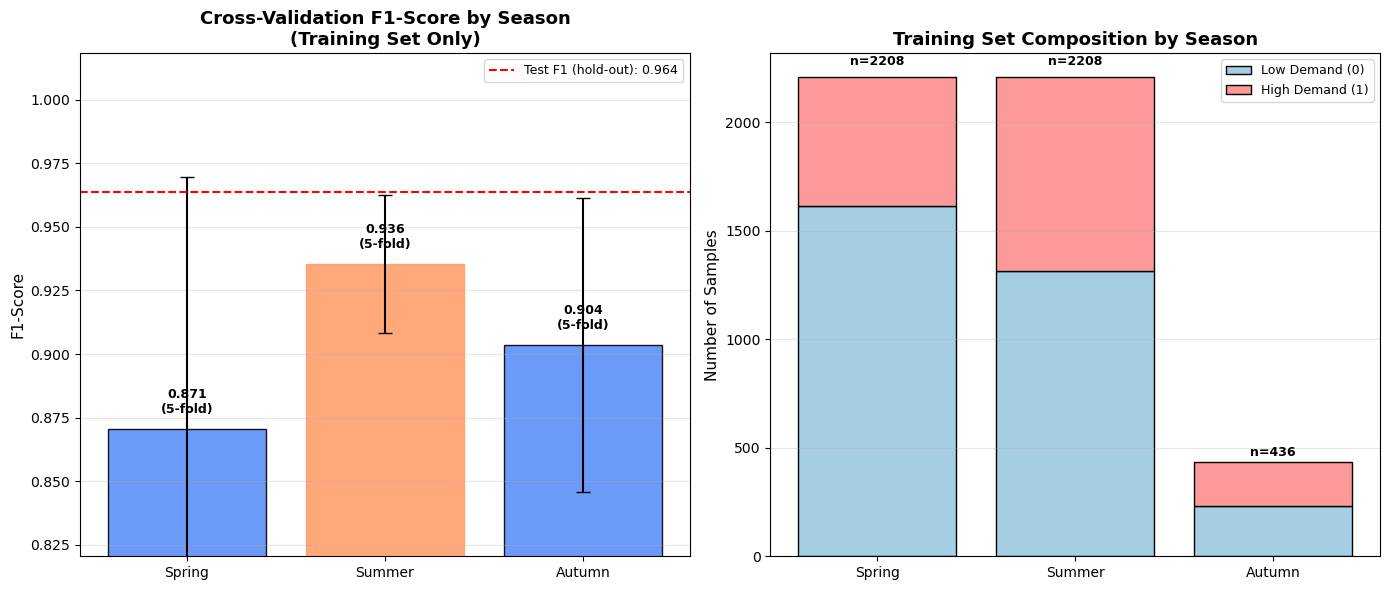


Seasonal CV Results (XGBoost):
        Samples  High Demand %  Mean F1  Std F1  CV Folds
Spring   2208.0           26.8   0.8706  0.0992       5.0
Summer   2208.0           40.5   0.9355  0.0271       5.0
Autumn    436.0           46.8   0.9035  0.0577       5.0


In [101]:
# Seasonal Learnability / Robustness
df_train = train_df.copy()

def infer_season_train(row):
    if row["Seasons_Spring"]:
        return "Spring"
    elif row["Seasons_Summer"]:
        return "Summer"
    elif row["Seasons_Winter"]:
        return "Winter"
    else:
        return "Autumn"

df_train["Season"] = df_train.apply(infer_season_train, axis=1)

xgb_for_cv = XGBClassifier(**final_xgb.get_params())
seasonal_cv_results = {}

for season in ["Spring", "Summer", "Autumn", "Winter"]:
    mask = df_train["Season"] == season
    X_season = X_train[mask]
    y_season = y_train[mask]

    print(f"=== Seasonal CV: {season} ===")
    print(f"Samples: {len(X_season)}")

    if len(X_season) < 150:
        print("  ⚠ Too few samples for reliable CV (skipping).")
        continue

    class_counts = y_season.value_counts()
    n0, n1 = class_counts.get(0, 0), class_counts.get(1, 0)
    print(f"  Class 0: {n0}, Class 1: {n1} ({(n1 / len(y_season)) * 100:.1f}% high-demand)")

    if len(class_counts) < 2 or n1 < 30:
        print("  ⚠ Insufficient positives for meaningful F1 (skipping).")
        continue

    max_folds = min(5, len(X_season) // 50)
    if max_folds < 2:
        print("  ⚠ Not enough data per fold for TimeSeriesSplit (skipping).")
        continue

    tscv_season = TimeSeriesSplit(n_splits=max_folds)

    cv_scores = cross_val_score(
        xgb_for_cv,
        X_season,
        y_season,
        cv=tscv_season,
        scoring=f1_scorer,
        n_jobs=-1
    )

    seasonal_cv_results[season] = {
        "samples": len(X_season),
        "high_demand_pct": (n1 / len(y_season)) * 100,
        "mean_f1": cv_scores.mean(),
        "std_f1": cv_scores.std(),
        "n_folds": max_folds
    }

    print(f"  F1-score (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Fold scores: {[f'{s:.4f}' for s in cv_scores]}")

# Seasonal visuals (F1 + composition)
if seasonal_cv_results:
    # Use only seasons that actually have CV results
    season_order = [s for s in ["Spring", "Summer", "Autumn", "Winter"]
                    if s in seasonal_cv_results]

    means = [seasonal_cv_results[s]["mean_f1"] for s in season_order]
    stds  = [seasonal_cv_results[s]["std_f1"] for s in season_order]
    folds = [seasonal_cv_results[s]["n_folds"] for s in season_order]

    # Composition from training set
    comp = (
        df_train.groupby(["Season", "High_Demand"])
        .size()
        .unstack(fill_value=0)
    )
    comp = comp.reindex(season_order)

    low_counts  = comp.get(0, pd.Series(0, index=season_order))
    high_counts = comp.get(1, pd.Series(0, index=season_order))

    x_pos = np.arange(len(season_order))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Left: F1 by season
    bars = ax1.bar(x_pos, means, yerr=stds, capsize=5,
                   color="#5b8ff9", edgecolor="black", alpha=0.9)

    # Highlight best season
    best_idx = int(np.argmax(means))
    bars[best_idx].set_color("#ff9f6b")

    # Dashed line at test F1
    ax1.axhline(test_f1, color="red", linestyle="--",
                label=f"Test F1 (hold-out): {test_f1:.3f}")

    # Annotate bars with value and folds
    for i, (m, f) in enumerate(zip(means, folds)):
        ax1.text(
            x_pos[i],
            m + 0.005,
            f"{m:.3f}\n({f}-fold)",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(season_order)
    ax1.set_ylabel("F1-Score", fontsize=11)
    ax1.set_title("Cross-Validation F1-Score by Season\n(Training Set Only)",
                  fontsize=13, fontweight="bold")
    ax1.set_ylim(bottom=max(0.7, min(means) - 0.05))
    ax1.legend(fontsize=9)
    ax1.grid(axis="y", alpha=0.3)

    # ----- Right: training composition by season -----
    ax2.bar(x_pos, low_counts, label="Low Demand (0)",
            color="#a6cee3", edgecolor="black")
    ax2.bar(x_pos, high_counts, bottom=low_counts,
            label="High Demand (1)", color="#fb9a99", edgecolor="black")

    for i, (lo, hi) in enumerate(zip(low_counts, high_counts)):
        total = lo + hi
        ax2.text(
            x_pos[i],
            total + max(total * 0.02, 10),
            f"n={int(total)}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(season_order)
    ax2.set_ylabel("Number of Samples", fontsize=11)
    ax2.set_title("Training Set Composition by Season", fontsize=13, fontweight="bold")
    ax2.legend(fontsize=9)
    ax2.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print numeric summary too
    summary_df = pd.DataFrame(seasonal_cv_results).T
    summary_df = summary_df[["samples", "high_demand_pct", "mean_f1", "std_f1", "n_folds"]]
    summary_df.columns = ["Samples", "High Demand %", "Mean F1", "Std F1", "CV Folds"]
    summary_df = summary_df.round({"High Demand %": 1, "Mean F1": 4, "Std F1": 4})

    print("\nSeasonal CV Results (XGBoost):")
    print(summary_df.to_string())
else:
    print("\nNo valid seasonal CV results (too few samples or positives per season).")
